In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
# jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
import jax.random as jr
from jax.tree_util import Partial

import hugegp as gp
# import hugegp_cuda as hgc
import jaxkd as jk

import matplotlib.pyplot as plt
import cmasher as cmr
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import time
from tqdm import tqdm

rng = jr.key(137)

In [ ]:
k1, k2 = jr.split(jr.key(99))
points = jr.normal(k1, shape=(100_000, 2))
xi = jr.normal(k2, shape=(len(points),))

graph = gp.build_graph(points, n0=1000, k=10)
covariance = gp.MaternCovariance(p=0)

values = gp.generate(graph, covariance, xi)
xi = gp.generate_inv(graph, covariance, values)
logdet = gp.generate_logdet(graph, covariance)

In [5]:
covariance = lambda r: jnp.exp(-0.5 * r**2) * (1+ 1e-5)

gp.generate(graph, covariance, xi)

Array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

In [ ]:
rng, k1 = jr.split(rng)
xi = jr.normal(k1, shape=(len(points),))
values = gp.generate(graph, gp.MaternCovariance(p=0), xi)
values

Array([0.96010643, 0.47773638, 0.9374918 , ..., 0.7024821 , 1.0812371 ,
       1.508366  ], dtype=float32)

0.8673439


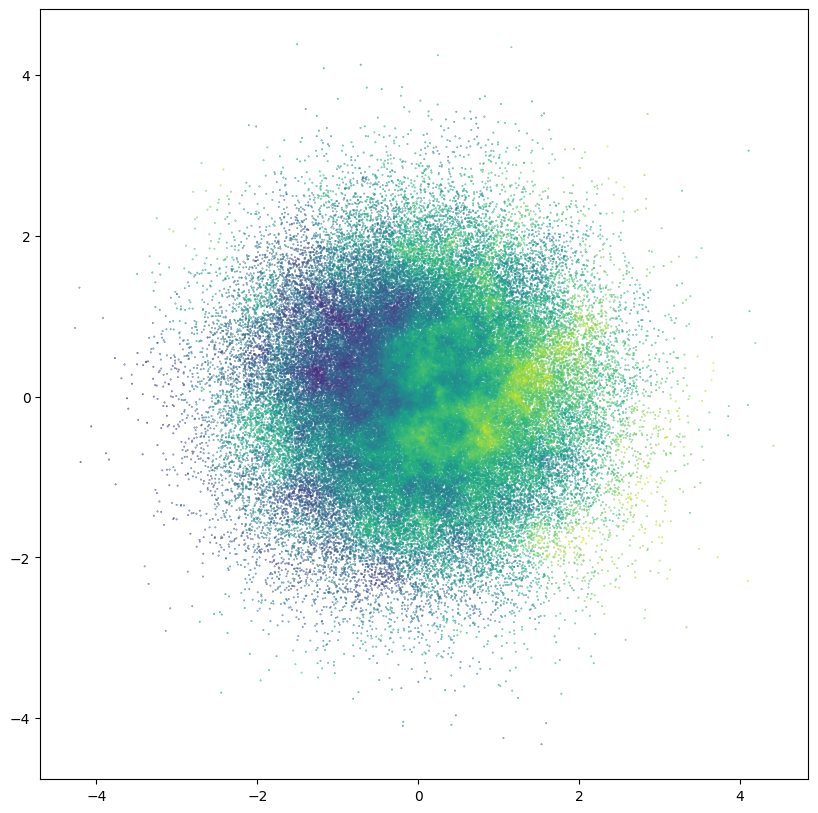

In [18]:
rng, key = jr.split(rng)
xi = jr.normal(key, shape=(len(points),))
cov_func = Partial(gp.matern_cov_p, p=0, cutoff=30.0, sigma=1.0)
values = gp.generate(points, neighbors, offsets, cov_func, xi)
print(values[0])

plt.figure(figsize=(10, 10))
plt.scatter(*points.T, c=values, s=.1)
plt.gca().set(aspect='equal')
plt.show()

# Try Bessel function

In [89]:
def bessel_cov(r, r0=0.1, eps=1e-4):
    result = jnp.sin(r / r0) / (r / r0)
    result = jnp.where(r == 0, 1.0 + eps, result)
    return result

In [101]:
rng, key = jr.split(rng)
points = jr.normal(key, shape=(10_000, 2))
offsets = gp.make_offsets(len(points), 1000, 1.3)
points, neighbors, indices = gp.build_jax_graph(points, offsets=offsets, k=10, cuda=True)

In [103]:
rng, key = jr.split(rng)
xi = jr.normal(key, shape=(len(points),))

true_values = gp.generate_dense(points, bessel_cov, xi)
values = gp.generate(points, neighbors, offsets, bessel_cov, xi)

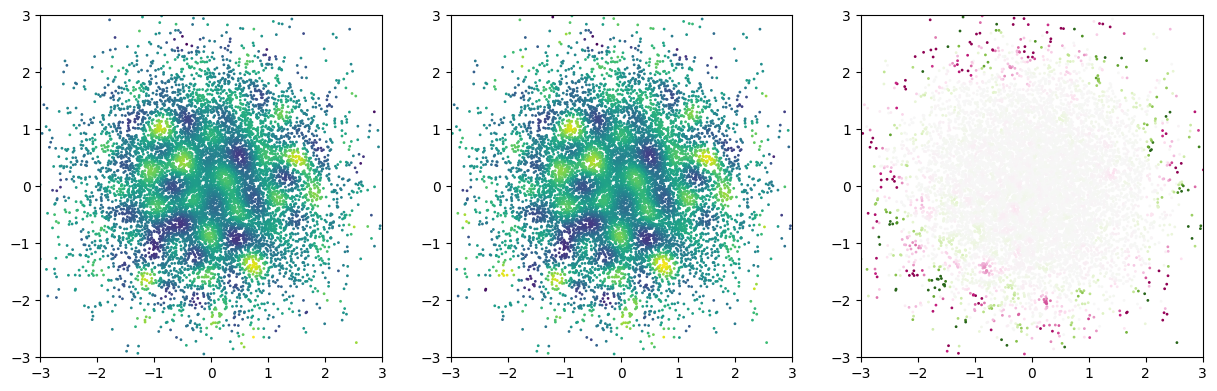

In [104]:
fig, axes = plt.subplots(figsize=(15,5), ncols=3)
axes[0].scatter(*points.T, c=true_values, s=1)
axes[1].scatter(*points.T, c=values, s=1)
axes[2].scatter(*points.T, c=true_values - values, s=1, cmap='PiYG', vmin=-1, vmax=1)
for ax in axes:
    ax.set(aspect='equal', xlim=(-3,3), ylim=(-3,3))
plt.show()

# Compare low number with exact

In [63]:
rng, key = jr.split(rng)
points = jr.normal(key, shape=(5_000, 2))
offsets = gp.make_offsets(len(points), 500, 1.3)
points, neighbors, indices = gp.build_jax_graph(points, offsets=offsets, k=20, cuda=True)
gp.check_graph(points, neighbors, offsets, indices)

In [64]:
rng, key = jr.split(rng)
xi = jr.normal(key, shape=(5_000,))

true_values = gp.generate_dense(points, gp.matern_cov, xi)
values = gp.generate(points, neighbors, offsets, gp.matern_cov, xi)

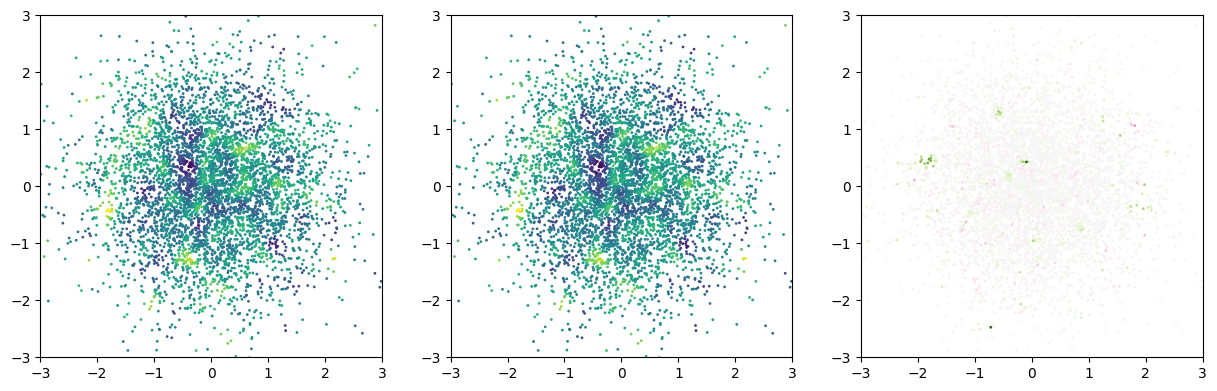

In [65]:
fig, axes = plt.subplots(figsize=(15,5), ncols=3)
axes[0].scatter(*points.T, c=true_values, s=1)
axes[1].scatter(*points.T, c=values, s=1)
axes[2].scatter(*points.T, c=true_values - values, s=1, cmap='PiYG', vmin=-1, vmax=1)
for ax in axes:
    ax.set(aspect='equal', xlim=(-3,3), ylim=(-3,3))
plt.show()